In [1]:
import numpy                 as     np
import numpy.linalg          as     npl                 
import scipy                 as     sp
from   scipy                 import ndimage    as ndi
import pandas as pd
import seaborn as sns
import re

from   skimage               import data
from   skimage.util          import img_as_float
from   skimage.filters       import gabor_kernel
from   sklearn.preprocessing import scale

from   numbers               import Number   

import os, sys, math, itertools, collections

%matplotlib notebook
#%gui qt
import matplotlib
import matplotlib.pyplot     as     plt

import neuropythy            as     neuro
import neuropythy.freesurfer as     nfs

for p in ['/home/billbrod/Documents/SCO-test-data/Freesurfer_subjects', '/Volumes/server/Freesurfer_subjects/']:
    if p not in nfs.subject_paths():
        nfs.add_subject_path(p)

import sco

import model_comparison_script

def reload_sco():
    reload(sys.modules['sco.core'])
    reload(sys.modules['sco.anatomy.core'])
    reload(sys.modules['sco.stimulus.core'])
    reload(sys.modules['sco.pRF.core'])
    reload(sys.modules['sco.normalization.core'])
    reload(sys.modules['sco.anatomy'])
    reload(sys.modules['sco.stimulus'])
    reload(sys.modules['sco.pRF'])
    reload(sys.modules['sco.normalization'])
    reload(sys.modules['sco'])
    reload(sys.modules['sco.model_comparison'])
    import sco

In [39]:
# this should only be used for testing, otherwise, use makefile as below
# stimuli_idx = [69, 70, 71, 72]
# model_df, results = model_comparison_script.main("stimuli.mat", stimuli_idx, range(3,6), 'test-sub', model_df_path='./test.csv')

Now, use the Makefile to create the full dataframe. This works but I feel like it takes longer then it should and it doesn't print things along the way, which is annoying.

In [38]:
%%bash
export PATH=$PATH:/Applications/MATLAB_R2014a8.3.app/bin/
make fullclean
make MATLAB_soc_model_params.csv

Process is terminated.


Load in the stimuli, stimuli info, and model dataframe so we don't need to do this in the call to visualize_model_comparison

In [2]:
stimuli_idx = np.asarray(range(156))+69
model_df = pd.read_csv("MATLAB_soc_model_params.csv")
stimulus_model_names = sco.model_comparison.core._load_pkl_or_mat("soc_model_params_image_names.mat", 'image_names')
stimuli_descriptions = sco.model_comparison.core._load_pkl_or_mat("sco/model_comparison/stimuliNames.mat", 'stimuliNames')
stimuli_descriptions = stimuli_descriptions[0, stimuli_idx]
stimuli_descriptions = np.asarray([i[0] for i in stimuli_descriptions])
stimuli = sco.model_comparison.core._load_pkl_or_mat("stimuli.mat", 'images')
stimuli = stimuli[0, :]

Set the conditions and titles you want to visualize for. Entries of `conditions` are either strings (in which case we plot those stimuli whose corresponding `stimuli_descriptions` equals that value) or lists of ints (in which case we plot the stimuli whose indices correspond to those ints)

In [3]:
conditions = ['grating_ori', 'grating_contrast']
titles = ['orientations', 'gratings']

<IPython.core.display.Javascript object>


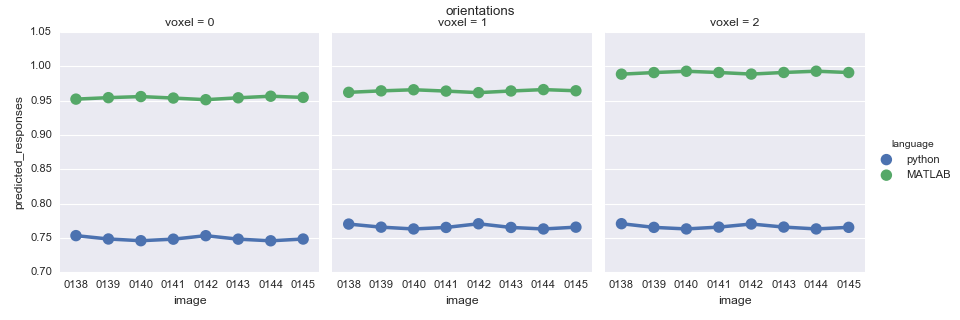

<IPython.core.display.Javascript object>


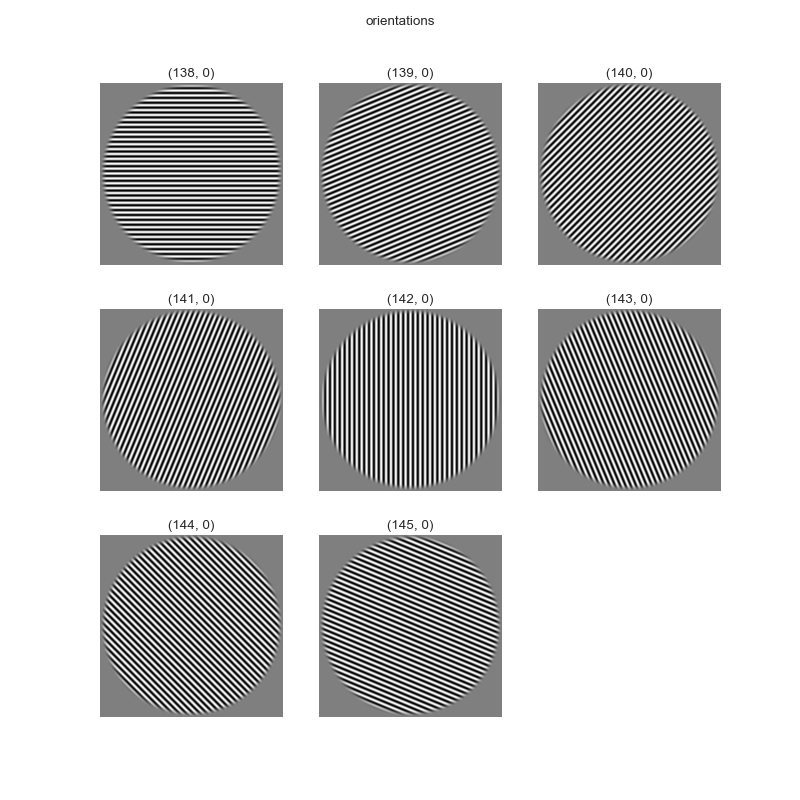

<IPython.core.display.Javascript object>


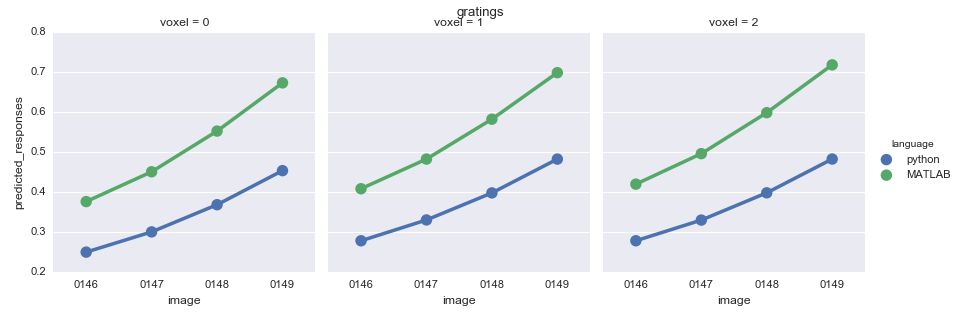

<IPython.core.display.Javascript object>


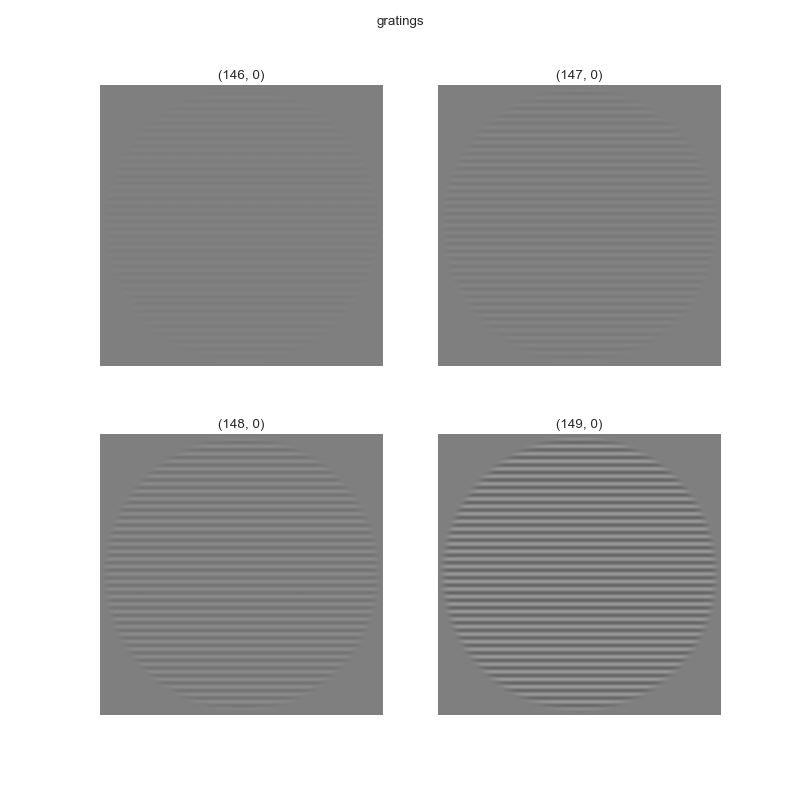

In [4]:
sco.model_comparison.visualize_model_comparison(conditions, titles, model_df, stimulus_model_names, stimuli_descriptions, stimuli, stimuli_idx)

In [27]:
condition_title = 'orientations'
condition = ['grating_ori' == name for name in stimuli_descriptions]

In [55]:
condition_title = 'grating'
condition = ['grating_contrast' == name for name in stimuli_descriptions]

In [57]:
condition_title = 'plaid'
condition = ['plaid_contrast' == name for name in stimuli_descriptions]

In [59]:
condition_title = 'circular'
condition = ['circular_contrast' == name for name in stimuli_descriptions]

In [7]:
condition_title = 'sparse'
condition = ['pattern_sparse' == name for name in stimuli_descriptions]

In [36]:
condition_title = 'test'
condition = range(131, 138)

<IPython.core.display.Javascript object>


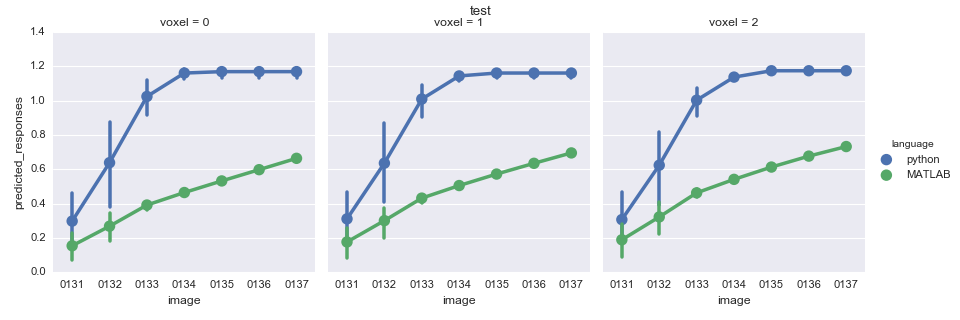

In [37]:
plot_df = sco.model_comparison.core._create_plot_df(condition, stimuli_idx, stimulus_model_names, model_df)
#plot_df=plot_df[(plot_df.language=='MATLAB')&(plot_df.voxel==0)]

g=sns.factorplot(data=plot_df,y='predicted_responses',x='image',hue='language', col='voxel', col_wrap=3, 
                 legend_out=True)#, kind='strip',jitter=True)
g.fig.suptitle(condition_title)
g.fig.subplots_adjust(top=.9, right=.9)

<IPython.core.display.Javascript object>


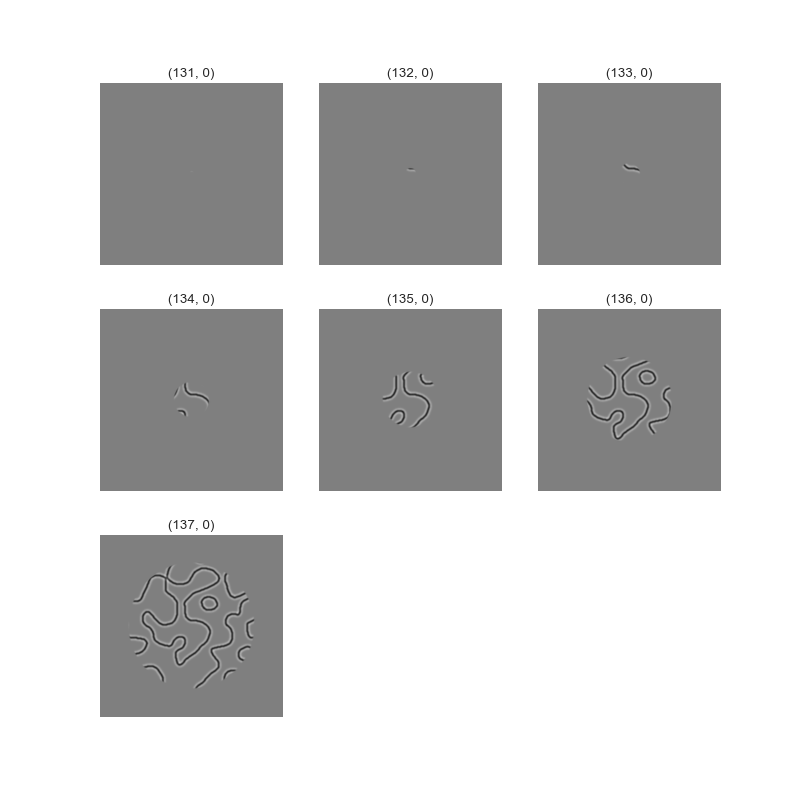

In [38]:
_ = sco.model_comparison.core._plot_stimuli(condition, stimuli_idx, stimuli)